In [21]:
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from os import getcwd
import wget
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# step 1, dealing with data

In [18]:
training=wget.download('https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip',bar=None)
testing=wget.download('https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip',bar=None)

In [19]:
zip_ref=zipfile.ZipFile(training,'r')
zip_ref.extractall('D:/win_Downloads/horse-or-humnan')
zip_ref=zipfile.ZipFile(testing,'r')
zip_ref.extractall('D:/win_Downloads/validation-horse-or-humnan')

In [24]:
train_datagen=ImageDataGenerator(rescale = 1./255.,
                                 rotation_range = 40,
                                 width_shift_range = 0.2,
                                 height_shift_range = 0.2,
                                 shear_range = 0.2,
                                 zoom_range = 0.2,
                                 horizontal_flip = True)

test_datagen = ImageDataGenerator(
    rescale = 1./255.
)

train_generator=train_datagen.flow_from_directory('D:/win_Downloads/horse-or-humnan',
                                                  batch_size=64,
                                                  class_mode='binary',
                                                  target_size=(150,150)
                                                 )

                                                  
validation_generator =  test_datagen.flow_from_directory(
    'D:/win_Downloads/validation-horse-or-humnan',
    batch_size=64,
    class_mode='binary',
    target_size=(150,150)
)

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [26]:
#call backs
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.999):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks=myCallback()

# step 2, dealing with pre trained model

In [30]:
weights_file=wget.download('https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5',bar=None)

In [31]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file=weights_file

pre_trained_model=InceptionV3(input_shape=(150,150,3),
                              include_top=False,
                              weights=None)

pre_trained_model.load_weights(local_weights_file)

In [32]:
for layer in pre_trained_model.layers:
    layer.trainable=False
    
pre_trained_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_282 (Conv2D)             (None, 74, 74, 32)   864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_282 (Bat (None, 74, 74, 32)   96          conv2d_282[0][0]                 
__________________________________________________________________________________________________
activation_282 (Activation)     (None, 74, 74, 32)   0           batch_normalization_v1_282[0][0] 
__________________________________________________________________________________________________
conv2d_283

max_pooling2d_15 (MaxPooling2D) (None, 3, 3, 768)    0           mixed7[0][0]                     
__________________________________________________________________________________________________
mixed8 (Concatenate)            (None, 3, 3, 1280)   0           activation_353[0][0]             
                                                                 activation_357[0][0]             
                                                                 max_pooling2d_15[0][0]           
__________________________________________________________________________________________________
conv2d_362 (Conv2D)             (None, 3, 3, 448)    573440      mixed8[0][0]                     
__________________________________________________________________________________________________
batch_normalization_v1_362 (Bat (None, 3, 3, 448)    1344        conv2d_362[0][0]                 
__________________________________________________________________________________________________
activation

In [35]:
last_layer=pre_trained_model.get_layer('mixed7')
last_output=last_layer.output


x=tf.keras.layers.Flatten()(last_output)
x=tf.keras.layers.Dense(1024,activation='relu')(x)
x=tf.keras.layers.Dropout(0.2)(x)
x=tf.keras.layers.Dense(1,activation='sigmoid')(x)

# step 3, actual model

In [37]:
from tensorflow.keras.optimizers import RMSprop
model = tf.keras.Model(pre_trained_model.input, x) 

model.compile(
    optimizer=RMSprop(lr=0.0001), 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

In [38]:
history = model.fit_generator(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[callbacks]
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
17/17 [==============================] - 97s 6s/step - loss: 0.4616 - acc: 0.8218 - val_loss: 0.0197 - val_acc: 0.9922
Epoch 2/50
17/17 [==============================] - 86s 5s/step - loss: 0.1238 - acc: 0.9572 - val_loss: 0.0120 - val_acc: 1.0000
Epoch 3/50
17/17 [==============================] - 86s 5s/step - loss: 0.0597 - acc: 0.9805 - val_loss: 0.0018 - val_acc: 1.0000
Epoch 4/50
17/17 [==============================] - 88s 5s/step - loss: 0.1192 - acc: 0.9581 - val_loss: 0.0251 - val_acc: 0.9922
Epoch 5/50
17/17 [==============================] - 87s 5s/step - loss: 0.0299 - acc: 0.9893 - val_loss: 0.0024 - val_acc: 1.0000
Epoch 6/50
17/17 [==============================] - 88s 5s/step - loss: 0.0956 - acc: 0.9611 - val_loss: 0.0229 - val_acc: 0.9961
Epoch 7/50
17/17 [==============================] - 87s 5s/step - loss: 0.0434 - acc: 0.9893 - val_loss: 0.0911 - val_acc: 0.9766
Epoch 8/50
17/17 [========================

# step 4, after training

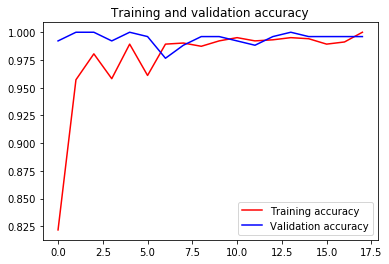

<Figure size 432x288 with 0 Axes>

In [40]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()